In [1]:
import os
import itertools
from time import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import SVC
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [2]:
# Divide the data into training data and validation data
# depending upon percentage of training data that must be used
def seperateData(allList, percentage, path, length ):
    
    trainLen = int (length* (percentage/100.0))
    trainList = [path + "/" + allList[i] for i in range(trainLen)]
    valList = [path + "/" + allList[i] for i in range(trainLen+1, length)]
    return trainList, valList
    

In [3]:
categories = os.listdir("101_ObjectCategories/")
# Object to store all the item details
objects = dict()
for name in categories:
    path = "./101_ObjectCategories/" + name
    temp = os.listdir(path)
    numberOfImages = len(temp)
    #print name 
    #print temp
    #print numberOfImages
    path = "./101_ObjectCategories/" + name
    trainList, valList = seperateData(temp, 85, path, numberOfImages)
    
    #objects[name] = dict(numberOfImages = numberOfImages)
    objects[name] = dict(
        numberOfImages = numberOfImages,
        trainingData = trainList,
        validationData= valList
    )


In [4]:
"""
for i in objects:
    print objects[i]
"""

'\nfor i in objects:\n    print objects[i]\n'

In [5]:
"""image_mat = io.imread(objects['sunflower']['trainingData'][0], as_grey=True)
io.imshow(image_mat)"""

"image_mat = io.imread(objects['sunflower']['trainingData'][0], as_grey=True)\nio.imshow(image_mat)"

In [6]:
def flattenImage(image =None):
    if image is not None:
        image2DMatrix = resize(io.imread(image, as_grey=True), (300, 167))
        imageVector = []
        for row in image2DMatrix:
            #print row
            for pixel in row:
                imageVector.append(pixel)
        
        # Testing (OK - TESTED)
        """
        image_mat_valid = image2DMatrix
        image_vector_valid = []
        for i in range(0, len(image_mat_valid)):
            for j in range(0, len(image_mat_valid[0])):
                image_vector_valid.append(image_mat_valid[i][j])
                
        print "TEST: ", image2DMatrix[-1][-1]
        print image_vector_valid == imageVector
        # OK (TESTED)
        """
        
        return imageVector
            
    else:
        raise IOError("Invalid Inputs")

In [7]:
# INPUT: Object with json format of validation and training data images
# OUTPUT: training image matrix:  which containst the images which are to used for training
#         label array: which contains the label corresponding to the given row of the training image matrix
def prepareTrainingData(imagesPerClass = 1, objects = None):
    trainingImageMatrix = []
    trainingLabel = []
    if objects is not None:
        for i in objects:
            if imagesPerClass < objects[i]['trainingData']:
                x = objects[i]['trainingData'][:imagesPerClass]
            else:
                x = objects[i]['trainingData']
            for j in x:
                trainingImageMatrix.append(flattenImage(j))
                trainingLabel.append(i)
        return trainingImageMatrix, trainingLabel 

    else:
        raise IOError("Give the valid input")

In [8]:
#flattenImage(image = objects['sunflower']['trainingData'][0])

In [9]:
print "Preparing training data"
trainingMatrix, trainingLabels = prepareTrainingData(imagesPerClass = 10 , objects = objects)
print "Traning data prepared\n Length of training matrix = ",

Preparing training data
Traning data prepared
 Length of training matrix = 


In [10]:
print len(trainingMatrix)

1010


### Applying PCA for dimensionality Reduction

In [11]:
# Keeping track of time taken by PCA algorithm
t0 = time()
print "PCA Started"
pca = PCA(n_components=50, whiten=True).fit(trainingMatrix)
print "Time taken by PCA %0.3fs::" % (time() - t0)
pca.explained_variance_ratio_

PCA Started
Time taken by PCA 21.218s::


array([ 0.44027534,  0.05152309,  0.04304028,  0.02851926,  0.02450832,
        0.02198139,  0.01556437,  0.01526241,  0.01141861,  0.0109184 ,
        0.00909966,  0.0084253 ,  0.00804339,  0.00776662,  0.00720269,
        0.0070676 ,  0.00526938,  0.00501909,  0.00481673,  0.00453654,
        0.00438057,  0.00419996,  0.00396713,  0.00379915,  0.0036469 ,
        0.00341137,  0.00315421,  0.00313075,  0.00284443,  0.00275808,
        0.00260729,  0.00260027,  0.00252644,  0.00242987,  0.0023175 ,
        0.00216594,  0.0021577 ,  0.00212244,  0.00207466,  0.00203396,
        0.00194512,  0.00193419,  0.00185499,  0.00177074,  0.00174932,
        0.00170831,  0.00165874,  0.00159767,  0.00157635,  0.00152751])

In [12]:
# projecting the input data on the eigenfaces orthonormal basis
print "Projecting the input data values"
t0 = time()
X_train_pca = pca.transform(trainingMatrix)

# The below line is currently not needed..Moreover, the code corresponding to
# validation matrix has been changed
# X_test_pca = pca.transform(validation_matrix)

print "Time taken for projection = %0.3fs" % (time() - t0)
print X_train_pca

Projecting the input data values
Time taken for projection = 12.410s
[[ 0.61526614 -0.81244153  1.73162781 ..., -2.41694565 -0.61488453
  -2.09565736]
 [ 0.30492132  0.73136907 -0.96240133 ...,  0.21734953  0.75392272
  -0.26757773]
 [ 0.39101205 -0.34043336  1.48806841 ...,  0.5413706  -0.11702148
   0.23747234]
 ..., 
 [ 0.14925871 -1.36738251  0.00912432 ..., -0.11943827 -0.09357356
   0.13337292]
 [ 0.92670604  0.03095425 -1.1386558  ..., -0.61086161 -1.84725394
   3.17859932]
 [-1.16644114 -1.32375174  1.07548534 ...,  0.14037713  1.02337287
   0.64155657]]


## Below code will run against each query to make prediction

In [13]:
"""
using kNN algorithm to find (k) nearest neighbours on complete dataset(training matrix), value of k(n_neighbours) 
is assigned to 100 for optimal behaviour
"""

def kNN(k, image_transform):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X_train_pca)
    
    distances, indices = neigh.kneighbors(image_transform)
    return indices[0]

# checking if the neighbours have similar labels. If yes then we can return this common label wihthout training SVM
def check_similarity(indices):
    flag = 0
    for i in range(0, len(indices)):
        for j in range(0, len(indices)):
            if trainingLabels[i] != trainingLabels[j]:
                flag = 1
                break
        if flag == 1:
            break
    # if labels are similar return or print the result, else train the SVM on neighbors matrix
    if flag == 0:
        return 0
    else:
        return 1


# Training SVM classifier only on k nearest neighbors
# GridSearchCV search over all the possible combinations of parameters of SVM classifier and choose the best one
def SVM(near_train, near_label, image_transform):
    t0 = time()
    # Here 'C' and 'gamma' are parameters provided as argument to SVM classifier
    param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
    classifier = GridSearchCV(SVC(kernel="rbf", class_weight="balanced"), param_grid)

    classifier = classifier.fit(near_train, near_label)
    print "Time taken for training SVM classifier %0.3fs\n" % (time() - t0)

    # Display the optimal value of parameters found by grid search
    print "Best Estimator found by grid search ::"
    print classifier.best_estimator_
    
    # Predicting using trained classifier
    return classifier.predict(image_transform)

In [14]:
# Driver function for calling transforming image and calling kNN-SVM classifiers

def make_prediction(image_array =[], k = None, originalLabel = None):
    if image is not None and k is not None and originalLabel is not None:
        # Convert the vector into a numpy array and fit it using pca  
        flat_image_array = np.array(image_array, dtype= float).reshape(1,-1)
        image_transform = pca.transform(flat_image_array)

        indices = kNN(k, image_transform)
        flag = check_similarity(indices)
        if flag == 0:
            # predicted image
            prediction = trainingLabels[indices[0]]
            print "\n(Prediction made by kNN classifier only)"
        else:
            # constructing new train_matrix and label_matix of neighbours
            near_train = []
            near_label = []
            for index in indices:
                near_train.append(X_train_pca[index])
                near_label.append(trainingLabels[index])
            # calling SVM on limited number of training examples(neighbors)
            prediction = SVM(near_train, near_label, image_transform)
            prediction = prediction[0] # label returned as a list, extracting string label from list
            print "\n(Prediction made using both kNN and SVM)"

        # displaying output
        print "Predicted label of image:"
        print prediction
        print "\nOriginal label of image:"
        print originalLabel

        print "\n\n"
        print "Chosen image is displayed below:"
        io.imshow(io.imread(image, as_grey=True))
        return (prediction == originalLabel)
    else: 
        raise IOError("Some of the inputs are not valid")

/home/a/miniconda2/envs/alt-env/lib/python2.7/site-packages/sklearn/model_selection/_split.py:579: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Time taken for training SVM classifier 5.785s

Best Estimator found by grid search ::
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

(Prediction made using both kNN and SVM)
Predicted label of image:
schooner

Original label of image:
sunflower



Chosen image is displayed below:
False
Total Time taken = 6.02588391304


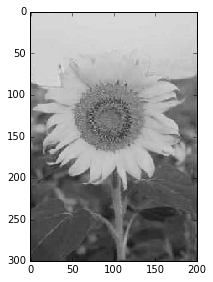

In [15]:
label = "sunflower"
image = objects[label]['validationData'][1]
image_array = flattenImage(image = image)
start = time()
print make_prediction(image_array = image_array , k = 50, originalLabel =label)
print "Total Time taken =", time()- start

### Prepare to find the mean accuracy of the classifier

In [19]:
def count_validation(objects):
    count =  0
    m = float("inf")
    for i in objects:
        temp = len(objects[i]['validationData'])
        m = min(m, temp)
        #print temp
        count += temp
    print m
    return count

In [20]:
print "Total number of validation data = ", count_validation(objects)

Total number of validation data =  4
1249


In [21]:
# INPUT: Object with json format of validation and training data images
# OUTPUT: validation image matrix:  which containst the images which are to used for validation
#         label array: which contains the label corresponding to the given row of the validation image matrix
def prepareValidationData(numberOfImages = 5, objects = None):
    validationImageMatrix = []
    labels = []
    start = time()
    if objects is not None:
        for i in objects:
            print "class = ", i
            for j in objects[i]['validationData'][:numberOfImages]:
                validationImageMatrix.append(flattenImage(j))
                labels.append(i)
        print "Total time taken to prepare validation matrix = ", time()-start
        return validationImageMatrix, labels 
        
    else:
        raise IOError("Give the valid input")

In [22]:
validationMatrix, validationLabels = prepareValidationData(numberOfImages = 5 , objects = objects)

class =  llama
class =  lotus
class =  laptop
class =  brain
class =  chandelier
class =  chair
class =  stop_sign
class =  joshua_tree
class =  sunflower
class =  accordion
class =  mandolin
class =  scorpion
class =  ewer
class =  schooner
class =  dragonfly
class =  stegosaurus
class =  menorah
class =  crocodile
class =  cannon
class =  watch
class =  sea_horse
class =  snoopy
class =  tick
class =  Motorbikes
class =  flamingo
class =  stapler
class =  electric_guitar
class =  emu
class =  saxophone
class =  brontosaurus
class =  bonsai
class =  lobster
class =  umbrella
class =  gramophone
class =  panda
class =  car_side
class =  pigeon
class =  revolver
class =  rhino
class =  buddha
class =  windsor_chair
class =  Leopards
class =  flamingo_head
class =  soccer_ball
class =  bass
class =  trilobite
class =  kangaroo
class =  gerenuk
class =  pagoda
class =  ibis
class =  Faces
class =  dalmatian
class =  cup
class =  octopus
class =  headphone
class =  pyramid
class =  scissor

In [23]:
print len(validationLabels)
print len(validationMatrix)

502
502


In [24]:
# Custom Built accuracy function to find the accuracy of the 
# classifer for the given set of validation data
def customAccuracy(validationMatrix = None , validationLabels = None):
    if validationMatrix is not None and validationLabels is not None:
        correct = 0 
        incorrect = 0
        n = len(validationLabels)
        start = time()
        for i in range(n):
            this_start = time()
            verdict = make_prediction(image_array = validationMatrix[i], k = 500, originalLabel = validationLabels[i])
            if verdict :
                correct += 1
            this_end = time()-this_start
            print "i = %s, verdict = %s, time = %s" %(str(i), str(verdict), str(this_end))
        end = time() - start
        print "total time taken =", end
        print "Total number of correct predictions are", correct
        print "----Finding accuracy ----"
        accuracy =  float(correct)/ float(n)
        return accuracy
    else: 
        raise IOError("Some of the inputs are not valid")

Time taken for training SVM classifier 38.310s

Best Estimator found by grid search ::
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

(Prediction made using both kNN and SVM)
Predicted label of image:
windsor_chair

Original label of image:
llama



Chosen image is displayed below:
i = 0, verdict = False, time = 38.5604269505
Time taken for training SVM classifier 36.613s

Best Estimator found by grid search ::
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

(Prediction made using both kNN and SVM)
Predicted label of image:
lamp

Original label of image:
llama



Chosen image is displayed below:
i = 1, verdict = False, tim

KeyboardInterrupt: 

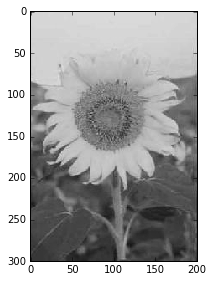

In [25]:
customAccuracy(validationMatrix = validationMatrix, validationLabels = validationLabels)

## Accuracy of the classifier

In [ ]:
start = time()
print "PCA on validation matrix started"
X_test_pca = pca.transform(validationMatrix)
print "PCA Completed. Time taken = ", time()-start
accuracy = classifier.score(X_test_pca, validationLabels)

In [ ]:
print accuracy

In [ ]:
import random
print random.sample(range(1,20), 4)